# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Optimising LDA topic model for Interpretability

</font>
</div>

# LDA
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>
    
- **Latent Dirichlet Allocation** (LDA) assumes each document consists of a combination of topics, and each topic consists of a combination of words.
- It then approximates probability distributions of topics in a given document and of words in a given topic. For example:
   - Document 1: Topic1 = 0.33, Topic2 = 0.33, Topic3 = 0.33
   - Topic 1: Product = 0.39, Payment = 0.32, Store = 0.29
- LDA is a type of Bayesian Inference Model. It assumes that the topics are generated before documents, and infer topics that could have generated the corupus of documents (a review = a document). 
- The dimensionality K of Dirichlet distribution (aka # of topics) is assumed to be known and fixed and needs to be provided. This is generally not extremely easy to do and lack if intuitiveness. We'll try to address this now. 

</font>
</div>

# Imports
<hr style="border:2px solid black"> </hr>


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np
from stop_word_list import *
from clean_text import *
import gensim
from gensim import corpora
# Change in import see: https://stackoverflow.com/questions/66759852/no-module-named-pyldavis
import pyLDAvis.gensim_models #as gensimvis
import matplotlib.pyplot as plt
import json
%matplotlib inline

Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


# Load dataset
<hr style="border:2px solid black"> </hr>

- Amazon Office Product reviews.
- See references to download the dataset.

In [3]:
# Load the data
data = []
for line in open('reviews_Office_Products_5.json', 'r'):
    data.append(json.loads(line))

In [4]:
df = pd.DataFrame(data)

In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A32T2H8150OJLU,B00000JBLH,ARH,"[3, 4]","I bought my first HP12C in about 1984 or so, a...",5.0,"A solid performer, and long time friend",1094169600,"09 3, 2004"
1,A3MAFS04ZABRGO,B00000JBLH,"Let it Be ""Alan""","[7, 9]",WHY THIS BELATED REVIEW? I feel very obliged t...,5.0,"Price of GOLD is up, so don't bury the golden ...",1197676800,"12 15, 2007"
2,A1F1A0QQP2XVH5,B00000JBLH,Mark B,"[3, 3]",I have an HP 48GX that has been kicking for mo...,2.0,"Good functionality, but not durable like old HPs",1293840000,"01 1, 2011"
3,A49R5DBXXQDE5,B00000JBLH,R. D Johnson,"[7, 8]",I've started doing more finance stuff recently...,5.0,One of the last of an almost extinct species,1145404800,"04 19, 2006"
4,A2XRMQA6PJ5ZJ8,B00000JBLH,Roger J. Buffington,"[0, 0]",For simple calculations and discounted cash fl...,5.0,Still the best,1375574400,"08 4, 2013"


In [6]:
# Extract only reviews text
reviews = pd.DataFrame(df.reviewText)

In [7]:
reviews

,reviewText
0,"I bought my first HP12C in about 1984 or so, a..."
1,WHY THIS BELATED REVIEW? I feel very obliged t...
2,I have an HP 48GX that has been kicking for mo...
3,I've started doing more finance stuff recently...
4,For simple calculations and discounted cash fl...
...,...
53253,What I like about this scale is you can power ...
53254,This Accuteck ShipPro digital scale works very...
53255,"I ship a lot of stuff. I sell small parts, ma..."
53256,This is a great little scale to have. It can w...


# Clean dataset
<hr style="border:2px solid black"> </hr>

In [8]:
# Cleaning up takes some time, so I have reduced the dataset down to 1000
reviews = reviews[:1000]

In [9]:
reviews

,reviewText
0,"I bought my first HP12C in about 1984 or so, a..."
1,WHY THIS BELATED REVIEW? I feel very obliged t...
2,I have an HP 48GX that has been kicking for mo...
3,I've started doing more finance stuff recently...
4,For simple calculations and discounted cash fl...
...,...
995,Scotch Gift Wrap Tape is the one and only tape...
996,It's been a few decades since Scotch delighted...
997,Works great for gift wrapping. I buy a 3 pack...
998,Tis the season to wrap presents so I put this ...


In [10]:
clean_reviews = clean_all(reviews, 'reviewText')

/Users/gm_main/Desktop/DataScienceFolder/GitHub/NLP-Natural-Language-Processing-Notes/tutorials/clean_text.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].map(ascii_rm)
/Users/gm_main/Desktop/DataScienceFolder/GitHub/NLP-Natural-Language-Processing-Notes/tutorials/clean_text.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].map(lambda x: x.lower())
/Users/gm_main/Desktop/DataScienceFolder/GitHub/NLP-Natural-Language-Processing-Notes/tutorials/c

In [11]:
clean_reviews.head(10)

,reviewText
0,b i buy my first hp c in about or so and it se...
1,b why this belate review I feel very obliged t...
2,b i have an hp gx that have be kick for more t...
3,b i ve start do more finance stuff recently an...
4,b for simple calculation and discount cash flo...
5,b while I do not have an mba it be hard to bel...
6,b i ve have an hp c ever since they be first a...
7,b bought this for my boss because he lose his ...
8,b this be a well design simple calculator that...
9,b i love this calculator big number and calcul...


# Form Bigrams & Trigrams
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- We want to identify bigrams and trigrams so we can concatenate them and consider them as one word. Bigrams are phrases containing 2 words e.g. ‘social media’, where ‘social’ and ‘media’ are more likely to co-occur rather than appear separately. Likewise, trigrams are phrases containing 3 words that more likely co-occur e.g. ‘Proctor and Gamble’.
- We use Pointwise Mutual Information score to identify significant bigrams and trigrams to concatenate. We also filter bigrams or trigrams with the filter (noun/adj, noun), (noun/adj,all types,noun/adj) because these are common structures pointing out noun-type n-grams.
- This helps the LDA model better cluster topics.
- Moreover, we'd like to try to avoid to rank only single words. When you are asked, about most common topic, people are likely to reply with a short sentence rather than by keywords.

</font>
</div>

In [12]:
[comment.split() for comment in clean_reviews.reviewText]

[['b',
  'i',
  'buy',
  'my',
  'first',
  'hp',
  'c',
  'in',
  'about',
  'or',
  'so',
  'and',
  'it',
  'serve',
  'I',
  'faithfully',
  'until',
  'when',
  'I',
  'lose',
  'it',
  'while',
  'travel',
  'I',
  'search',
  'for',
  'another',
  'one',
  'to',
  'replace',
  'it',
  'but',
  'find',
  'one',
  'difficult',
  'to',
  'come',
  'by',
  'in',
  'my',
  'area',
  'so',
  'I',
  'decide',
  'to',
  'buy',
  'up',
  'and',
  'purchase',
  'an',
  'hp',
  'g',
  'what',
  'a',
  'mistake',
  'I',
  'know',
  'that',
  'many',
  'people',
  'view',
  'the',
  'hp',
  'g',
  'now',
  'g',
  'as',
  'the',
  'flagship',
  'of',
  'the',
  'hp',
  'line',
  'but',
  'for',
  'I',
  'that',
  'be',
  'a',
  'disaster',
  'the',
  'g',
  'may',
  'be',
  'powerful',
  'but',
  'use',
  'it',
  'be',
  'extremely',
  'counterintuitive',
  'and',
  'the',
  'manual',
  'be',
  'sketchy',
  'at',
  'well',
  'the',
  'c',
  'on',
  'the',
  'other',
  'hand',
  'do',
  'what'

In [13]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents(
    [comment.split() for comment in clean_reviews.reviewText])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [14]:
bigram_scores[:10]

[(('highly', 'recommend'), 9.044496592031916),
 (('don', 't'), 9.006142330576308),
 (('mouse', 'pad'), 8.814704236512549),
 (('return', 'address'), 7.992783947721289),
 (('gift', 'wrap'), 7.9889212703173325),
 (('laser', 'printer'), 7.266503793696595),
 (('inkjet', 'printer'), 7.166252320061092),
 (('peel', 'off'), 6.691107142357108),
 (('easy', 'peel'), 6.28935000235138),
 (('i', 've'), 6.2173595145551275)]

In [15]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents(
    [comment.split() for comment in clean_reviews.reviewText])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [16]:
trigram_scores[:10]

[(('return', 'address', 'label'), 13.474714783400877),
 (('a', 'lot', 'of'), 10.173163911103902),
 (('easy', 'to', 'use'), 9.360617152735795),
 (('I', 'do', 'not'), 8.415783826208198),
 (('if', 'you', 'be'), 8.268710519200454),
 (('be', 'easy', 'to'), 7.588088497904842),
 (('these', 'label', 'be'), 6.954562460578138),
 (('b', 'this', 'be'), 6.867701766370402),
 (('this', 'be', 'a'), 6.0833085427239055),
 (('it', 'be', 'a'), 5.403617203240515)]

In [17]:
# Create pandas dataframe
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis=0, ascending=False, inplace=True)

In [18]:
bigram_pmi.head(3)

,bigram,pmi
0,"(highly, recommend)",9.044497
1,"(don, t)",9.006142
2,"(mouse, pad)",8.814704


In [19]:
# Create pandas dataframe
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis=0, ascending=False, inplace=True)

In [20]:
trigram_pmi.head(3)

,trigram,pmi
0,"(return, address, label)",13.474715
1,"(a, lot, of)",10.173164
2,"(easy, to, use)",9.360617


In [21]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [22]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ', 'NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False
    return True

In [23]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:
                                              bigram_filter(bigram['bigram'])
                                              and bigram.pmi > 5, axis=1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram:
                                                 trigram_filter(
                                                     trigram['trigram'])
                                                 and trigram.pmi > 5, axis=1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(
    x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(
    x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [24]:
# examples of bigrams
bigrams[:10]

['mouse pad',
 'return address',
 'gift wrap',
 'laser printer',
 'inkjet printer',
 'easy peel',
 'work great',
 'address label']

In [25]:
# examples of trigrams
trigrams[:10]

['return address label']

In [26]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [41]:
clean_reviews.iloc[-1].reviewText

'b we use this tape when wrap christmas gift this year and I be really impressed with it on the foil wrap it show a little but any type of type show up well on foil wrap on regular decorate wrap it blend so well you could hardly see it would definitely buy it again'

In [28]:
reviews_w_ngrams = clean_reviews.copy()

In [29]:
reviews_w_ngrams.reviewText = reviews_w_ngrams.reviewText.map(
    lambda x: replace_ngram(x))

In [30]:
reviews_w_ngrams.head(2)

,reviewText
0,b i buy my first hp c in about or so and it se...
1,b why this belate review I feel very obliged t...


In [31]:
reviews_w_ngrams.iloc[0].reviewText

'b i buy my first hp c in about or so and it serve I faithfully until when I lose it while travel I search for another one to replace it but find one difficult to come by in my area so I decide to buy up and purchase an hp g what a mistake I know that many people view the hp g now g as the flagship of the hp line but for I that be a disaster the g may be powerful but use it be extremely counterintuitive and the manual be sketchy at well the c on the other hand do what I need in a way that make good sense to me if you be look for a solid reliable calculator the hp c may be for you it be programmable it do basic statistic well and many business application too the manual make sense you will be up and run in short order i m ready to set my g aside and move back to my old friend I do not even have to replace the battery in well over a decade of use hp c I be come home'

In [33]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.reviewText.map(lambda x: [word for word in x.split()
                                                              if word not in stop_word_list
                                                              and word not in english_names
                                                              and len(word) > 2])

In [34]:
reviews_w_ngrams.iloc[0]

['buy',
 'serve',
 'faithfully',
 'lose',
 'travel',
 'search',
 'replace',
 'difficult',
 'come',
 'area',
 'decide',
 'buy',
 'purchase',
 'mistake',
 'know',
 'people',
 'view',
 'flagship',
 'line',
 'disaster',
 'powerful',
 'use',
 'extremely',
 'counterintuitive',
 'manual',
 'sketchy',
 'hand',
 'need',
 'way',
 'good',
 'sense',
 'look',
 'solid',
 'reliable',
 'calculator',
 'programmable',
 'basic',
 'statistic',
 'business',
 'application',
 'manual',
 'sense',
 'run',
 'short',
 'order',
 'ready',
 'set',
 'aside',
 'old',
 'friend',
 'replace',
 'battery',
 'decade',
 'use',
 'come',
 'home']

In [35]:
reviews_w_ngrams.head()

0    [buy, serve, faithfully, lose, travel, search,...
1    [belate, review, feel, obliged, share, view, o...
2    [kick, year, year, old, flawless, month, numbe...
3    [start, finance, stuff, recently, went, look, ...
4    [simple, calculation, discount, cash, flow, go...
Name: reviewText, dtype: object

In [ ]:
stop

# Filter for only nouns
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Nouns are most likely indicators of a topic. For example, for the sentence ‘The store is nice’, we know the sentence is talking about ‘store’.
- The other words in the sentence provide more context and explanation about the topic (‘store’) itself.
- Therefore, filtering for the noun cleans the text for words that are more interpretable in the topic model.

</font>
</div>

In [36]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [37]:
final_reviews = reviews_w_ngrams.map(noun_only)

In [60]:
final_reviews

0      [travel, search, area, purchase, mistake, line...
1      [belate, review, feel, share, view, workhorse,...
2      [year, year, month, number, trouble, press, re...
3      [start, finance, stuff, time, value, money, ca...
4      [calculation, discount, cash, flow, use, gradu...
                             ...                        
995    [scotch, gift_wrap, tape, tape, tape, course, ...
996    [decade, scotch, delight, tape, scotch, tape, ...
997    [work_great, year, wrap, christmas, birthday, ...
998    [tis, season, wrap, tape, use, glance, stuff, ...
999    [use, tape, wrap, christmas, gift, year, foil,...
Name: reviewText, Length: 998, dtype: object

# LDA Model
<hr style="border:2px solid black"> </hr>

In [61]:
dictionary = corpora.Dictionary(final_reviews)

In [62]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

# Optimize # of k topics
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>
    
- LDA requires that we specify the number of topics that exists in a corpus of text.
- There are several common measures that can be optimised, such as predictive likelihood, perplexity, and coherence.
- Much literature has indicated that maximizing coherence, particularly a measure named Cv (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), leads to better human interpretability.
- This measure assesses the interpretability of topics given the set of words in generated topics. Therefore, we will optimise this measure.
- Since `eval_only` calculates perplexity metric, we can set it to `None` to save time, as we will use a different metric called Cv.
    
</font>
</div>

In [63]:
coherence = []
# 5 to 10 topic
for k in range(5, 10):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word=dictionary, passes=40,
                   iterations=200, chunksize=10000, eval_every=None)

    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k, cm.get_coherence()))

Round: 5


Slow version of gensim.models.doc2vec is being used
Slow version of gensim.models.doc2vec is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of Fasttext is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used

Round: 6


Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used

Round: 7


Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used

Round: 8


Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used

Round: 9


Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used

In [45]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

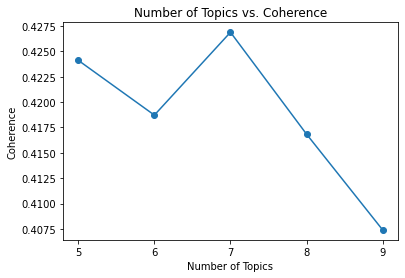

In [46]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

<div class="alert alert-info">
<font color=black>
    
- The improvement stops to significantly improve after 15 topics.
- It is not always where the highest Cv is, so we can try a couple to see which has the best result.
- We'll try 15 and 23 here. 
- Adding topics can help reveal further sub topics. Nonetheless, if the same words start to appear across multiple topics, the number of topics is too high.

</font>
</div>

In [47]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [48]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=23, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

<div class="alert alert-info">
<font color=black>
    
- `Passes`: The number of times model iterates through the whole corpus
- `Iterations`: The number of iterations the model trains on each pass
- `Chunk size`: Number of rows that are taken to train the model each 

</font>
</div>

In [49]:
# To show initial topics
ldamodel.show_topics(15, num_words=10, formatted=False)

[(0,
  [('label', 0.068430364),
   ('use', 0.04784519),
   ('print', 0.033289455),
   ('sheet', 0.019253133),
   ('work', 0.018807018),
   ('printer', 0.016971545),
   ('envelope', 0.0166074),
   ('line', 0.014321926),
   ('point', 0.014142458),
   ('need', 0.012048947)]),
 (1,
  [('label', 0.11343268),
   ('use', 0.051525023),
   ('print', 0.040888667),
   ('avery', 0.03578184),
   ('sheet', 0.033314127),
   ('printer', 0.026808038),
   ('template', 0.020752547),
   ('peel', 0.017944304),
   ('word', 0.017909769),
   ('work', 0.01713181)]),
 (2,
  [('phone', 0.1098746),
   ('cord', 0.025735157),
   ('number', 0.019438839),
   ('quality', 0.017997405),
   ('price', 0.017892892),
   ('work', 0.014632773),
   ('use', 0.013896612),
   ('button', 0.0135434205),
   ('trimline', 0.012894374),
   ('telephone', 0.012886912)]),
 (3,
  [('tape', 0.08776691),
   ('use', 0.059118494),
   ('mount', 0.05666736),
   ('wall', 0.034338277),
   ('surface', 0.030487478),
   ('product', 0.026277242),
   (

In [50]:
# To show initial topics
ldamodel2.show_topics(23, num_words=10, formatted=False)

[(0,
  [('use', 0.03710484),
   ('calculator', 0.02979511),
   ('price', 0.02461535),
   ('work', 0.017449778),
   ('purchase', 0.017185945),
   ('line', 0.016644316),
   ('need', 0.014085402),
   ('display', 0.013706812),
   ('year', 0.013503536),
   ('way', 0.011815217)]),
 (1,
  [('calculator', 0.0869555),
   ('use', 0.038625125),
   ('function', 0.019506926),
   ('year', 0.015243714),
   ('time', 0.013178664),
   ('value', 0.011024698),
   ('battery', 0.010728797),
   ('issue', 0.010396569),
   ('finance', 0.010142551),
   ('money', 0.009951874)]),
 (2,
  [('phone', 0.0948854),
   ('cord', 0.036704443),
   ('trimline', 0.02223478),
   ('quality', 0.019606885),
   ('model', 0.01533906),
   ('handset', 0.013599291),
   ('design', 0.012321207),
   ('wall', 0.011487335),
   ('button', 0.011364665),
   ('sound', 0.011145838)]),
 (3,
  [('tape', 0.078415394),
   ('mount', 0.055687618),
   ('use', 0.050843433),
   ('wall', 0.03970264),
   ('surface', 0.03959406),
   ('product', 0.03512522

23 topics yielded clearer results, so we'll go with this...

# Relevancy
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>
    
- Sometimes, words that are ranked as top words for a given topic may be ranked high because they are globally frequent across text in a corpus. Relevancy score helps to prioritize terms that belong more exclusively to a given topic. This can increase interpretability even more. The relevance of term `w` to topic `k` is defined as:
    
$r(w,k| \lambda) = \lambda log(\phi_{kw}) +(1-\lambda)log(\frac{\phi_{kw}}{p_{kw}})$

    
- where $\phi_{kw}$ is the probability of term w in topic k and $\frac{\phi_{kw}}{p_{kw}}$ is lift in term's probability within a topic to its marginal probability across the corpus (this helps discards globally frequent terms).
- **How to tune it?**
    - A lower lambda value gives more importance to the second term, which gives more importance to topic exclusivity. 
    - A higher lambda value gives more importance to the first term, which gives less importance to topic exclusivity. 
- We can use `Python’s pyLDAvis` interactive GUI to see this. Choose a value of 0.5 if undecided.

</font>
</div>

In [51]:
topic_data = pyLDAvis.gensim_models.prepare(
    ldamodel2, doc_term_matrix, dictionary, mds='pcoa')
pyLDAvis.display(topic_data)

/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/train

<div class="alert alert-info">
<font color=black>

- The pyLDAvis tool also gives two other important pieces of information. 
- The circles represent each topic.
- The distance between the circles visualizes how related topics are to each other.
- The above plot shows that our topics are quite distinct. 
- The dimensionality reduction can be chosen as PCA or t-sne. The above example uses t-sne.
- Additionally, the size of the circle represents how prevalent that topic is across the corpus of reviews. 

</font>
</div>

To extract the words for a given lambda:

In [52]:
all_topics = {}
num_terms = 10  # Adjust number of words to represent each topic
lambd = 0.6  # Adjust this accordingly based on tuning above
for i in range(1, 24):  # Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category ==
                                  'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance',
                                                    ascending=False).Term[:num_terms].values

In [53]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,label,print,sheet,avery,use,template,printer,word,peel,envelope
Topic 2,label,ink,printer,folder,file,use,brand,work,canon,avery
Topic 3,tape,scotch,gift_wrap,gift,wrap,roll,paper,magic,satin,giftwrap
Topic 4,paper,photo,epson,card,color,print,matte,quality,stock,printer
Topic 5,mount,wall,surface,tape,item,paint,product,use,poster,picture
Topic 6,card,product,wizard,avery,half,download,support,consumer,thank,web
Topic 7,tape,mount,door,stuff,thing,use,mirror,cat,shot,heat
Topic 8,calculator,function,finance,key,value,calculation,user,use,battery,press
Topic 9,product,gold,rule,business,version,use,standard,decision,owner,invitation
Topic 10,book,use,label,bulb,storage,light,incandescent,committee,time,community


We can see here that most topics are quite clear. In this case, they are clustered into the different products being talked about in the reviews. Some clear topics are:
- Printer products
- Scanner proudcts
- Printer Ink, pricing/quality
- School stationary
- Lamination
- Packing tape
- Mailing labels
- Markers
- Magnetic boards
- Workstation
- Binder
- Paper products
- Phone
- Post-its
- Storage/packing materials
- Mouse/keyboard
- Pencil
- Cutting
- File Organizer
- Business card
- Calculator
- Mailing materials
- Label maker

# Clean-up folder
<hr style="border:2px solid black"> </hr>

In [ ]:
# We are not pushing to git big file
!du -h reviews_Office_Products_5.json

In [ ]:
#!rm -rf reviews_Office_Products_5.json

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- [Amazon office review dataset](https://jmcauley.ucsd.edu/data/amazon/)
- [6 Tips for Interpretable Topic Models](https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2)
- [pyLDAvis paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
- [Latent Dirichlet Allocation and definition of hyperparameters](https://radimrehurek.com/gensim/models/ldamodel.html)
- https://www.cs.cmu.edu/~epxing/Class/10708-15/slides/LDA_SC.pdf<br>
- https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process

</font>
</div>

# Requirements
<hr style="border:2px solid black"> </hr>

In [ ]:
%load_ext watermark
%watermark -v -iv -m